In [1]:
# !pip install git+git://github.com/StochSS/sciope.git@master
import numpy as np
import sys
sys.path.insert(1, '/home/smatthe2/sciope')
sys.path.insert(1, '/home/smatthe2/GillesPy2')
import sciope
import gillespy2
from gillespy2 import Model, Species, Parameter, Reaction, Event, \
                      EventTrigger, EventAssignment
from gillespy2 import ODECSolver, ODESolver, SSACSolver, TauHybridCSolver

import matplotlib.pyplot as plt

# devils_2stage_inference

In [2]:
variables = {'juvenile_concentration': 0.49534348836011316, 
             'birth_rate': 0.055, 
             'maturity_rate': 0.04167, 
             'infection_rate_infected': 1.1e-05, 
             'infection_rate_diseased': 3.2e-05, 
             'incubation': 10, 
             'progression': 10.746230534983676, 
             'death_rate_juvenile': 0.006, 
             'death_rate_susceptible': 0.02335, 
             'death_rate_over_population': 2.3e-07, 
             'death_rate_infected': 0.01966, 
             'death_rate_diseased': .29134996217062514, 
             'DFTD_start': 97}
variables_orig = variables.copy()
total_time = np.arange(0, 421, 1)

In [3]:
import pandas as pd

pop_data = pd.read_csv('month_data/Devils_Dataset__Population_1985-2020.csv')

devil_pop = np.array(pop_data['Population'].iloc[:])
init_devils_pop = devil_pop[0]

obs = np.vstack([devil_pop]).reshape(1, 1, -1)
# print(obs)

In [4]:
class Devils2Stage(Model):
    def __init__(self, values=variables, events=None):
        Model.__init__(self, name="Devils DFTD 2-Stage Infection")
        self.volume = 1

        # Parameters
        birth_rate = Parameter(name="birth_rate", expression=values['birth_rate'])
        death_rate_juvenile = Parameter(name="death_rate_juvenile", expression=values['death_rate_juvenile'])
        maturity_rate = Parameter(name="maturity_rate", expression=values['maturity_rate'])
        death_rate_susceptible = Parameter(
            name="death_rate_susceptible", expression=values['death_rate_susceptible']
        )
        death_rate_over_population = Parameter(
            name="death_rate_over_population", expression=values['death_rate_over_population']
        )
        infection_rate_infected = Parameter(
            name="infection_rate_infected", expression=values['infection_rate_infected']
        )
        infection_rate_diseased = Parameter(
            name="infection_rate_diseased", expression=values['infection_rate_diseased']
        )
        incubation = Parameter(name="incubation", expression=values['incubation'])
        juvenile_concentration = Parameter(name="juvenile_concentration", expression=values['juvenile_concentration'])

        death_rate_infected = Parameter(name="death_rate_infected", expression=values['death_rate_infected'])
        progression = Parameter(name="progression", expression=values['progression'])
        death_rate_diseased = Parameter(name="death_rate_diseased", expression=values['death_rate_diseased'])
        DFTD_start = Parameter(name="DFTD_start", expression=values['DFTD_start'])
        
        self.add_parameter([birth_rate, death_rate_juvenile, maturity_rate, death_rate_susceptible, juvenile_concentration,
                            death_rate_over_population, infection_rate_infected, infection_rate_diseased,
                            incubation, death_rate_infected, progression, death_rate_diseased, DFTD_start])

        # Variables (initial values adjusted to observed data)
        initial_devil_population  = int(devil_pop[0])
        
        Juvenile = Species(
            name="Juvenile", mode="discrete",
            initial_value=round(initial_devil_population * values['juvenile_concentration'])
        )
        Susceptible = Species(
            name="Susceptible", mode="discrete",
            initial_value=round(initial_devil_population * (1 - values['juvenile_concentration']))
        )
        Exposed = Species(name="Exposed", initial_value=0, mode="discrete")
        Infected = Species(name="Infected", initial_value=0, mode="discrete")
        Diseased = Species(name="Diseased", initial_value=0, mode="discrete")
        Devils = Species(name="Devils", initial_value=initial_devil_population, mode="discrete")
        self.add_species([Juvenile, Susceptible, Exposed, Infected, Diseased, Devils])

                
        # Reactions
        Birth = Reaction(name="Birth",
            reactants={}, products={'Juvenile': 1, 'Devils': 1},
            propensity_function="birth_rate * (Susceptible + Exposed + Infected)"
        )
        Mature = Reaction(name="Mature",
            reactants={'Juvenile': 1}, products={'Susceptible': 1},
            propensity_function="Juvenile * maturity_rate"
        )
        Death_Diseased = Reaction(name="Death_Diseased",
            reactants={'Diseased': 1, 'Devils': 1}, products={},
            propensity_function="death_rate_diseased * Diseased"
        )
        Death_Diseased2 = Reaction(name="Death_Diseased2",
            reactants={'Diseased': 1, 'Devils': 1}, products={},
            propensity_function="death_rate_over_population * Diseased * (Devils - 1)"
        )
        Death_Exposed = Reaction(name="Death_Exposed",
            reactants={'Devils': 1, 'Exposed': 1}, products={},
            propensity_function="death_rate_susceptible * Exposed"
        )
        Death_Exposed2 = Reaction(name="Death_Exposed2",
            reactants={'Devils': 1, 'Exposed': 1}, products={},
            propensity_function="death_rate_over_population * Exposed * (Devils - 1)"
        )
        Death_Infected = Reaction(name="Death_Infected",
            reactants={'Infected': 1, 'Devils': 1}, products={},
            propensity_function="death_rate_infected * Infected"
        )
        Death_Infected2 = Reaction(name="Death_Infected2",
            reactants={'Infected': 1, 'Devils': 1}, products={},
            propensity_function="death_rate_over_population * Infected * (Devils-1)"
        )
        Death_Juvenile = Reaction(name="Death_Juvenile",
            reactants={'Juvenile': 1, 'Devils': 1}, products={},
            propensity_function="death_rate_juvenile * Juvenile"
        )
        Death_Juvenile2 = Reaction(name="Death_Juvenile2",
            reactants={'Juvenile': 1, 'Devils': 1}, products={},
            propensity_function="death_rate_over_population * Juvenile * (Devils-1)"
        )
        Death_Susceptible = Reaction(name="Death_Susceptible",
            reactants={'Susceptible': 1, 'Devils': 1}, products={},
            propensity_function="death_rate_susceptible * Susceptible"
        )
        Death_Susceptible2 = Reaction(name="Death_Susceptible2",
            reactants={'Susceptible': 1, 'Devils': 1}, products={},
            propensity_function="death_rate_over_population * Susceptible * (Devils-1)"
        )
        DFTD_Stage1 = Reaction(name="DFTD_Stage1",
            reactants={'Exposed': 1}, products={'Infected': 1},
            propensity_function="Exposed / incubation"
        )
        DFTD_Stage2 = Reaction(name="DFTD_Stage2",
            reactants={'Infected': 1}, products={'Diseased': 1},
            propensity_function="Infected / progression"
        )
        TransmissionD = Reaction(name="TransmissionD",
            reactants={'Susceptible': 1, 'Diseased': 1}, products={'Exposed': 1, 'Diseased': 1},
            propensity_function="infection_rate_diseased * Susceptible * Diseased"
        )
        TransmissionI = Reaction(name="TransmissionI",
            reactants={'Susceptible': 1, 'Infected': 1}, products={'Exposed': 1, 'Infected': 1},
            propensity_function="infection_rate_infected * Susceptible * Infected"
        )
        self.add_reaction([
            Birth, Mature, Death_Diseased, Death_Diseased2, Death_Exposed, Death_Exposed2, Death_Infected,
            Death_Infected2, Death_Juvenile, Death_Juvenile2, Death_Susceptible, Death_Susceptible2,
            DFTD_Stage1, DFTD_Stage2, TransmissionD, TransmissionI
        ])

        # Events
        
        et = EventTrigger(expression='t>=DFTD_start')
        ea1 = EventAssignment(variable=Susceptible, expression='Susceptible-1')
        ea2 = EventAssignment(variable=Infected, expression='1')
        introduce_dftd = Event(name='introduce_dftd', trigger=et, assignments=[ea1, ea2])
        self.add_event(introduce_dftd)
        if events is not None:
            self.add_event(events)

        # Timespan
        self.timespan(np.arange(0, 421, 1)) # month data tspan
        

In [5]:
model = Devils2Stage()
print(model)

Devils DFTD 2-Stage Infection

**********
Species
**********

Devils: 34615
Diseased: 0
Exposed: 0
Infected: 0
Juvenile: 17146
Susceptible: 17469

**********
Parameters
**********

DFTD_start: 97
birth_rate: 0.055
death_rate_diseased: 0.29134996217062514
death_rate_infected: 0.01966
death_rate_juvenile: 0.006
death_rate_over_population: 2.3e-07
death_rate_susceptible: 0.02335
incubation: 10
infection_rate_diseased: 3.2e-05
infection_rate_infected: 1.1e-05
juvenile_concentration: 0.49534348836011316
maturity_rate: 0.04167
progression: 10.746230534983676

**********
Reactions
**********

Birth
	Products
		Juvenile: 1
		Devils: 1
	Propensity Function: (birth_rate*((Susceptible+Exposed)+Infected))
DFTD_Stage1
	Reactants
		Exposed: 1
	Products
		Infected: 1
	Propensity Function: (Exposed/incubation)
DFTD_Stage2
	Reactants
		Infected: 1
	Products
		Diseased: 1
	Propensity Function: (Infected/progression)
Death_Diseased
	Reactants
		Diseased: 1
		Devils: 1
	Propensity Function: (death_rate_di

# Model Inference

In [6]:
%load_ext autoreload
%autoreload 2

from tsfresh.feature_extraction.settings import MinimalFCParameters
from sciope.utilities.priors import uniform_prior
from sciope.utilities.summarystats import auto_tsfresh
from sciope.utilities.distancefunctions import naive_squared, euclidean, manhattan
from sciope.inference.abc_inference import ABC
from sciope.inference.smc_abc import SMCABC
from sciope.utilities.epsilonselectors import RelativeEpsilonSelector
from sklearn.metrics import mean_absolute_error
import dask
from dask.distributed import Client

## Generate some fixed(observed) data based on default parameters of the model

In [7]:
def configure_simulation():
    solver = TauHybridCSolver(model=model, variable=True)
    kwargs = {
        "solver":solver
    }
    return kwargs

In [8]:
kwargs = configure_simulation()

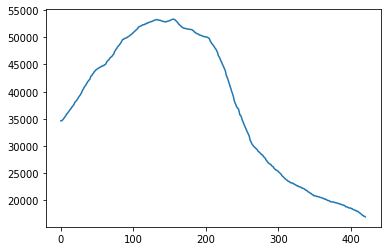

In [9]:
plt.plot(total_time, devil_pop)
# plt.plot(model.tspan, dfdt_pop)

In [10]:
solver = TauHybridCSolver(model, variable=True)

In [11]:
results = model.run(solver=solver)
results.plotplotly()

## Define prior distribution

In [12]:
# take default from mode 1 as reference
default_param = np.array(list(model.listOfParameters.items()))[:, 1]

print(default_param)

parameter_names = []
bound = []
mat_ind = 100
for i,exp in enumerate(default_param):
    if exp.name=='maturity_rate':
        mat_ind = i
    bound.append(float(exp.expression))
    parameter_names.append(exp.name)

print(parameter_names)
print(bound)
print(i)
# bound = np.log(bound)
# Set the bounds
bound = np.array(bound)
min_stand = bound * .75
max_stand = bound * 1.25
min_stand[mat_ind] = bound[mat_ind]
max_stand[mat_ind] = bound[mat_ind]

dmin = np.log(min_stand)
dmax = np.log(max_stand)
# dmin = bound * 0.5
# dmax = bound * 5.0

print(dmin)
print(dmax)
# Here we use uniform prior
uni_prior = uniform_prior.UniformPrior(dmin, dmax)

['DFTD_start', 'birth_rate', 'death_rate_diseased', 'death_rate_infected', 'death_rate_juvenile', 'death_rate_over_population', 'death_rate_susceptible', 'incubation', 'infection_rate_diseased', 'infection_rate_infected', 'juvenile_concentration', 'maturity_rate', 'progression']
[97.0, 0.055, 0.29134996217062514, 0.01966, 0.006, 2.3e-07, 0.02335, 10.0, 3.2e-05, 1.1e-05, 0.49534348836011316, 0.04167, 10.746230534983676]
12
[  4.28702891  -3.18810417  -1.52091219  -4.21685124  -5.40367788
 -15.5728686   -4.04484037   2.01490302 -10.63745673 -11.70529736
  -0.99018591  -3.17797383   2.08687297]
[  4.79785453  -2.67727854  -1.01008656  -3.70602561  -4.89285226
 -15.06204298  -3.53401474   2.52572864 -10.1266311  -11.19447173
  -0.47936029  -3.17797383   2.5976986 ]


In [13]:
from math import floor

## Define simulator

In [14]:
def set_model_parameters(params):
    # params - array, need to have the same order as model.listOfParameters
    variables = dict(zip(parameter_names, params))
    return variables

# Here we use the GillesPy2 Solver
def simulator(params, model):
    print('testing params:\n', params)
    params = np.exp(params)
    variables = set_model_parameters(params)
    print(variables)
#     model_update = set_model_parameters(params, model)
    res = model.run(solver=solver)
    devils = res['Devils']
    res = res.to_array()
    tot_res = np.asarray([x.T for x in res]) # reshape to (N, S, T)
    # should not contain timepoints
    tot_res = tot_res[:, 1:, :]
    
#     infected = res['I']

    return np.vstack([devils]).reshape(1, 1, -1)
#     return tot_res

# Wrapper, simulator function to abc should should only take one argument (the parameter point)
def simulator2(x):
    return simulator(x, model=model)

## Define summary statistics and distance function

In [15]:
res = model.run(solver=solver)
res.plotplotly()

In [16]:
# Function to generate summary statistics
summ_func = auto_tsfresh.SummariesTSFRESH()

# Distance
ed = euclidean.EuclideanDistance()
mh = manhattan.ManhattanDistance()

## Start local cluster using dask client

In [17]:
c = Client()

## Start abc instance

In [18]:
abc = SMCABC(obs,
                          sim=simulator2,
                          prior_function=uni_prior,
                          summaries_function=summ_func.compute,
                          distance_function=mh
                         )
# abc.compute_fixed_mean(1)

In [19]:
# First compute the fixed(observed) mean
# abc.compute_fixed_mean(chunk_size=2)

In [20]:
max_rounds = 12
eps_selector = RelativeEpsilonSelector(20, max_rounds)
with dask.config.set(schedular="processes", workers=20):
    print(c)
    res = abc.infer(num_samples=100, batch_size=10, chunk_size=1, eps_selector=eps_selector)

<Client: 'tcp://127.0.0.1:42707' processes=4 threads=8, memory=7.58 GiB>
Determining initial population using 20
Starting epsilon = 8937589.168277778


In [21]:
# mae_inference = mean_absolute_error(bound, abc.results['inferred_parameters'])
res[0]

{'accepted_samples': [array([  4.76169244,  -3.12318203,  -1.10676917,  -4.06299411,
          -5.36399852, -15.44050849,  -3.83586085,   2.04372044,
         -10.30176217, -11.70406949,  -0.87193031,  -3.17797383,
           2.44310821]),
  array([  4.46535114,  -2.98296934,  -1.45823095,  -3.94681108,
          -4.97729823, -15.51084995,  -3.83925176,   2.16865782,
         -10.27075918, -11.64209326,  -0.57545816,  -3.17797383,
           2.46118108]),
  array([  4.65996228,  -2.7109212 ,  -1.38566838,  -4.07184031,
          -5.21518643, -15.2068044 ,  -3.6443815 ,   2.04204009,
         -10.57273927, -11.26485543,  -0.50144693,  -3.17797383,
           2.09606841]),
  array([  4.43530497,  -2.69681756,  -1.33485181,  -4.10996982,
          -5.25800423, -15.06789993,  -3.82201244,   2.48769617,
         -10.19005576, -11.63685171,  -0.61347379,  -3.17797383,
           2.44342947]),
  array([  4.59340379,  -3.10580179,  -1.15019128,  -3.94293995,
          -5.29058865, -15.37654319

## Analysis

In [22]:
posterior = np.array(res[0]['accepted_samples'])

distributed.nanny - WARNING - Restarting worker


Left to Right:


distributed.nanny - WARNING - Restarting worker
distributed.nanny - WARNING - Restarting worker
<ipython-input-23-6d4f71f5317d>:17: UserWarning:

Attempting to set identical left == right == 0.04167 results in singular transformations; automatically expanding.

distributed.nanny - WARNING - Restarting worker


0: DFTD_start
1: birth_rate
2: death_rate_diseased
3: death_rate_infected
4: death_rate_juvenile
5: death_rate_over_population
6: death_rate_susceptible
7: incubation
8: infection_rate_diseased
9: infection_rate_infected
10: juvenile_concentration


<ipython-input-23-6d4f71f5317d>:13: UserWarning:

Attempting to set identical left == right == 0.04167 results in singular transformations; automatically expanding.

<ipython-input-23-6d4f71f5317d>:16: UserWarning:

Attempting to set identical bottom == top == 0.04167 results in singular transformations; automatically expanding.



11: maturity_rate
12: progression


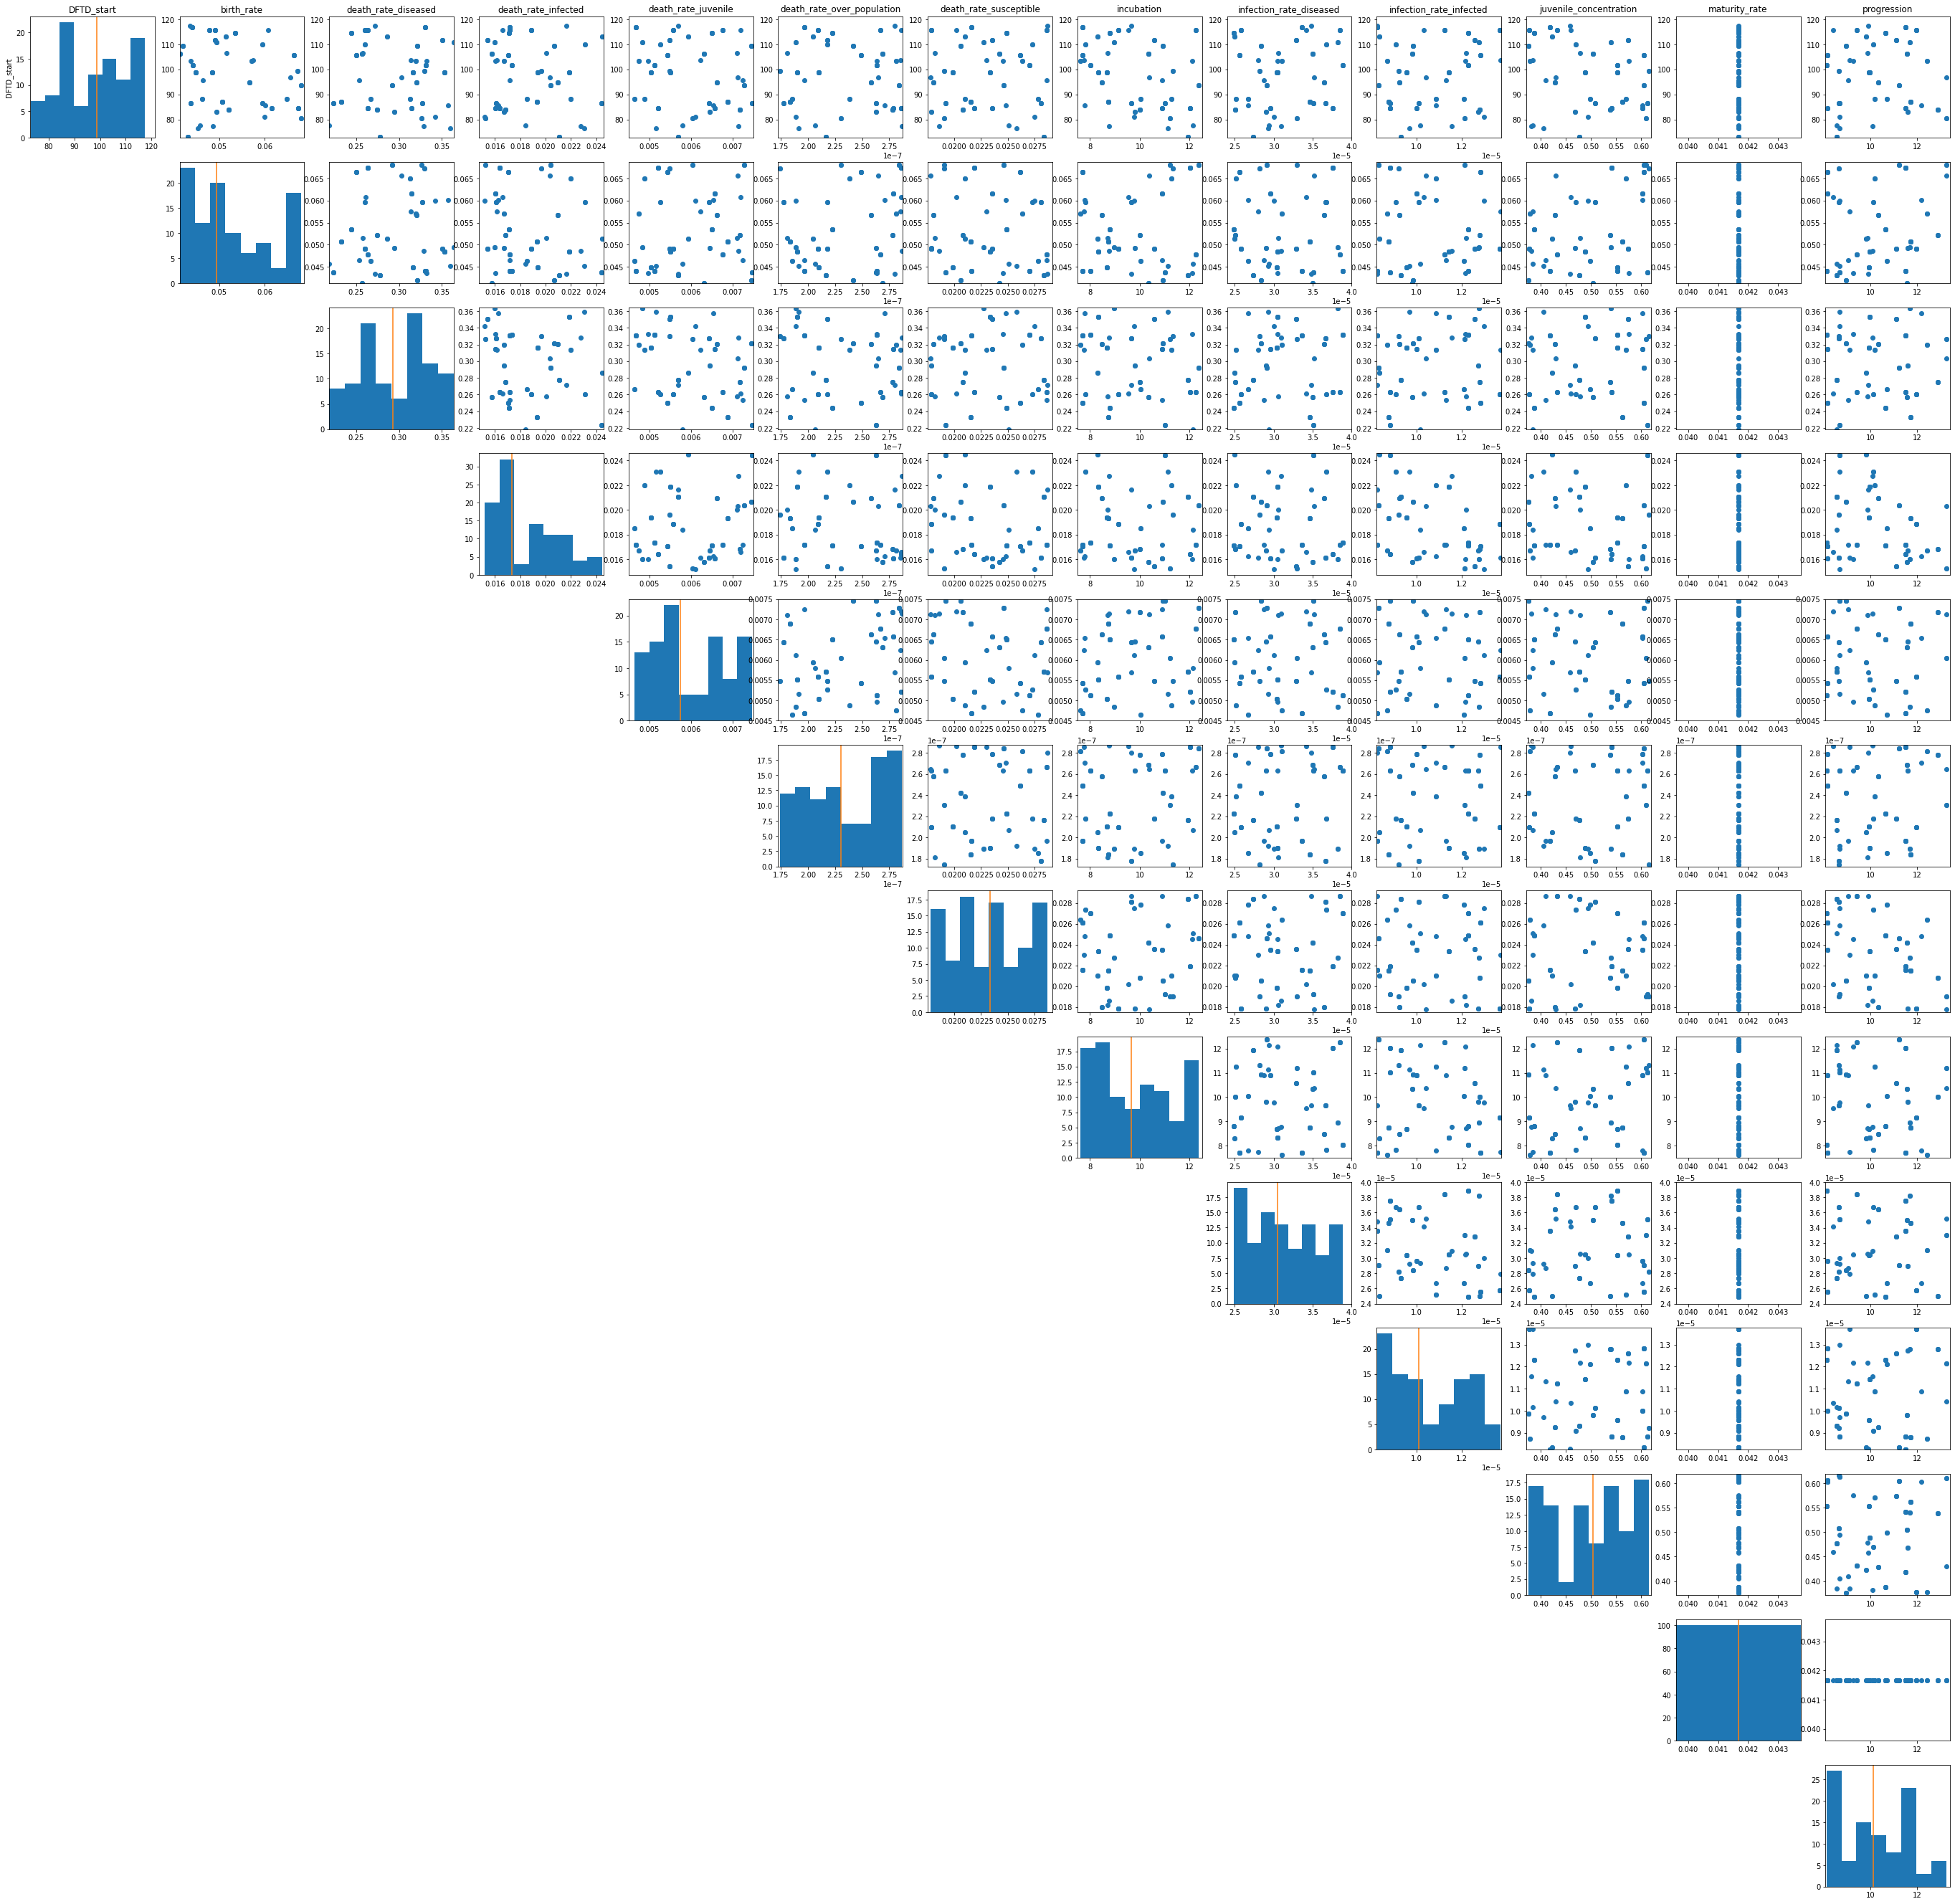

In [23]:
import pickle

fig, ax = plt.subplots(posterior.shape[1], posterior.shape[1])
print('Left to Right:')
for i in range(posterior.shape[1]):
    for j in range(posterior.shape[1]):
        if i > j:
            ax[i,j].axis('off')
        else:
            if i == j:
                ax[i,j].hist(np.exp(posterior[:,i]), bins = 'auto')
                ax[i,j].axvline(np.median(np.exp(posterior[:,i])), color = 'C1')
                ax[i,j].set_xlim(np.exp(dmin[i]), np.exp(dmax[i]))
            else:
                ax[i,j].scatter(np.exp(posterior[:,j]), np.exp(posterior[:,i]))
                ax[i,j].set_ylim(np.exp(dmin[i]), np.exp(dmax[i]))
                ax[i,j].set_xlim(np.exp(dmin[j]), np.exp(dmax[j]))
    print('{}: {}'.format(i, parameter_names[i]))
    ax[i,0].set_ylabel(parameter_names[i])
    ax[0,i].set_title(parameter_names[i])
fig.set_size_inches(48,48)
plt.savefig('devil-param-correlation-run2.png')
with open('fig-obj-run2.p', 'wb') as fig_obj_file:
    pickle.dump(fig, fig_obj_file)
with open('posterior-data-run2.p', 'wb') as posterior_data_file:
    pickle.dump(posterior, posterior_data_file)
# fig.tight_layout()

In [24]:
# for i in range(posterior.shape[0]):
#     res = simulator2(posterior[i,:])
#     plt.plot(res[0,:], color = 'C0', alpha = 0.02)
# #     ax[1].plot(res[0,1,:], color = 'C0', alpha = 0.02)
# plt.plot(obs[0,0,:], color = 'black', label = 'Observed Data')
# # ax[1].plot(obs[0,1,:], color = 'black', label = 'Observed Data')
# plt.title("Total Devil Population")
# # ax[1].set_title("Infected")
# plt.legend(loc='best')

In [25]:
# res = simulator2(posterior[10,:])
# print(res)
# plt.plot(res[0,:], color = 'C0', alpha = 0.02)
# #     ax[1].plot(res[0,1,:], color = 'C0', alpha = 0.02)
# plt.plot(obs[0,0,:], color = 'black', label = 'Observed Data')
# # ax[1].plot(obs[0,1,:], color = 'black', label = 'Observed Data')
# plt.title("Total Devil Population")
# # ax[1].set_title("Infected")
# plt.legend(loc='best')

In [26]:
best_ind = np.argmin(res[0]['distances'])

In [27]:
res[0]['distances'][best_ind]

4918368.75607204

In [28]:
print(posterior[best_ind])

[  4.33777444  -3.0967534   -1.02314646  -3.76890858  -5.26705278
 -15.46711311  -3.65642167   2.41060128 -10.43827771 -11.54255336
  -0.90275819  -3.17797383   2.15878603]


{'DFTD_start': 76.53701178437146, 'birth_rate': 0.045195696886673464, 'death_rate_diseased': 0.35946212546808104, 'death_rate_infected': 0.023077236416755263, 'death_rate_juvenile': 0.005158792279194819, 'death_rate_over_population': 1.9174238551678493e-07, 'death_rate_susceptible': 0.025824756975785377, 'incubation': 11.140657788023628, 'infection_rate_diseased': 2.9289610022707976e-05, 'infection_rate_infected': 9.708067049091301e-06, 'juvenile_concentration': 0.4054498080915116, 'maturity_rate': 0.04167, 'progression': 8.660617543402589}


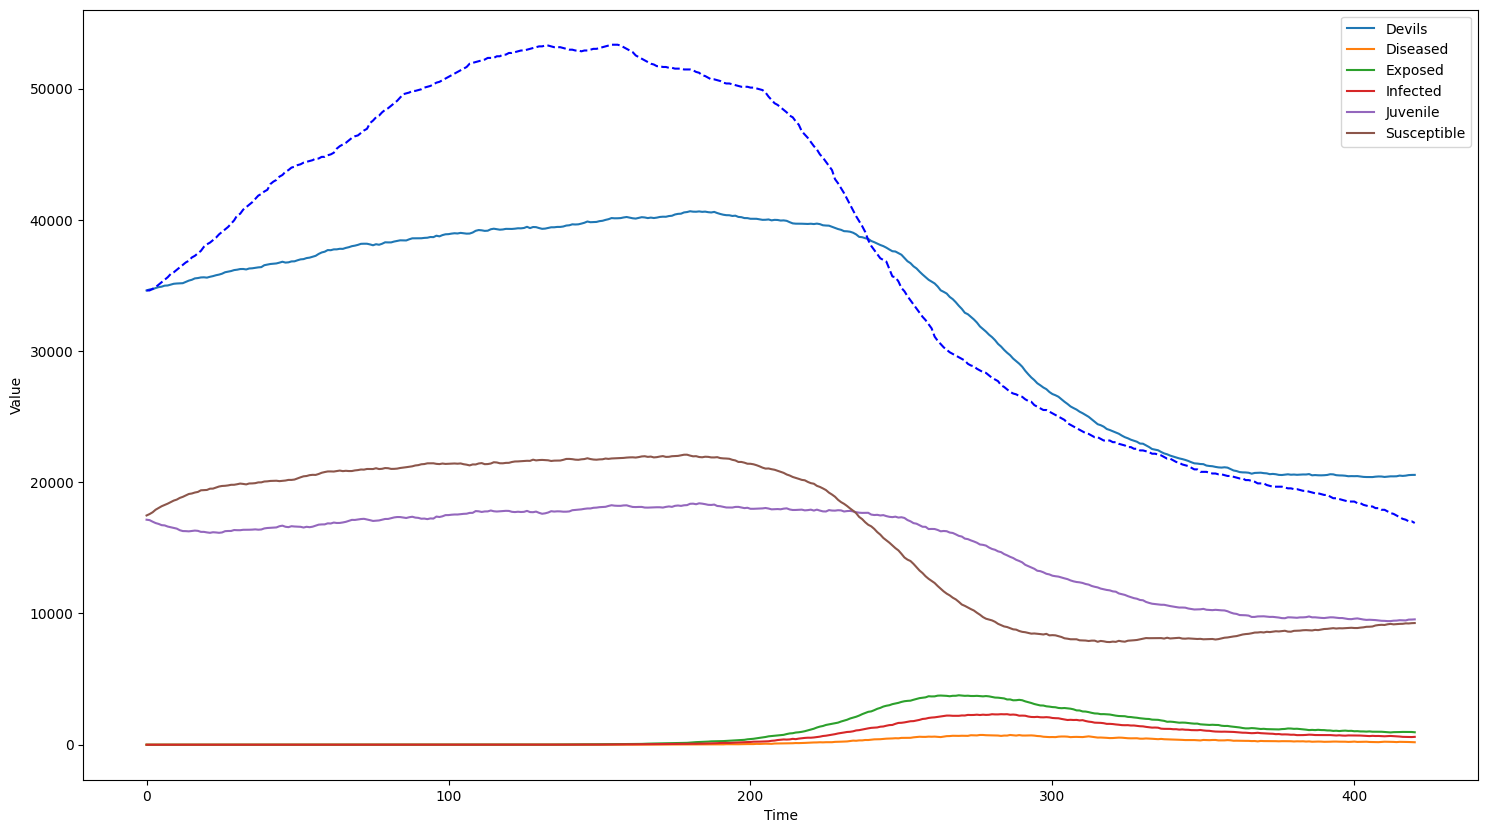

In [29]:
selected_vars = dict(zip(parameter_names, np.exp(posterior[best_ind])))
print(selected_vars)
test = model.run(solver=solver, variables=selected_vars)
# for spec in testb[0]:
#     if spec != 'time':
#             test[0][spec] = test[0][spec][:-1]
test.plot()
plt.plot(total_time, devil_pop, '--b')

In [30]:
np.shape(test[0]['time'])

(421,)

In [31]:
test[0]['time'].shape

(421,)